# SETUP

## import packages

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
import seaborn as sns
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA as mlabPCA
# scipy
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind
from scipy.stats import boxcox
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

## fill in database credentials

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

## query database and create data frame

In [3]:
# create engine with credentials
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# create data frame from sql query
df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# close engine
engine.dispose()

# INITIAL INSPECTION

## Inspect data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

### Save column names to a variable 

In [5]:
col_names = df.columns.to_list()
col_names

['Country',
 'Year',
 'Status',
 'Life expectancy ',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles ',
 ' BMI ',
 'under-five deaths ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 ' HIV/AIDS',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

### Which columns have NULL values?

In [6]:
# save off columns with null values to a list variable for later use
contains_null = []

# iterate through the columns
for col in col_names:
    # print the the columns with NULL values
    if df[col].isnull().sum() > 0:
        contains_null.append(col)

# inspect list of columns with NULL values
contains_null

['Life expectancy ',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 ' BMI ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

#### Observations: Data type inspection
- 2,938 rows
- 22 columns
- 16 float columns
- 4 int columns
- 2 object columns (likely String)
- 14 columns with NULL values

## Inspect columns and first few rows

In [7]:
df.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

#### Observations: Data frame first rows
 - data appears to align with data types reported by df.info

# DATA CLEANING

## Rename columns
- remove leading and trailing white spaces
- replace double space with single space

In [8]:
# iterate through the list of column names
for index in range(len(col_names)):
    # remove leading and trailing white spaces
    col_names[index] = col_names[index].strip()
    # replace double space with single space
    col_names[index] = col_names[index].replace('  ',' ')

# check results
col_names

['Country',
 'Year',
 'Status',
 'Life expectancy',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles',
 'BMI',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness 1-19 years',
 'thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [9]:
# replace dataframe column names with updated list
df.columns = col_names

## Convert Year variable to String
 - Year will be used as a Categorical variable rather than continuous

In [10]:
df['Year'] = df['Year'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null object
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-nul

## Sort variables into categorical or continuous

In [11]:
# categorical variables
cat_vars = ['Country', 'Year', 'Status']

# continuous variables
cont_vars = ['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
             'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness 1-19 years',
             'thinness 5-9 years', 'Income composition of resources', 'Schooling']

## Deal with NULL values

### Update list of columns with NULL values

In [12]:
# empty out original list with original column names
contains_null = []

# iterate through the columns
for col in col_names:
    # print the the columns with NULL values
    if df[col].isnull().sum() > 0:
        contains_null.append(col)

# inspect list of columns with NULL values
contains_null

['Life expectancy',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 'BMI',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'GDP',
 'Population',
 'thinness 1-19 years',
 'thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [13]:
# save off copy of original data
df_orig = df.copy()

### View percentage of NULL values for each column

In [14]:
# iterate through the columns
for col in contains_null:
    # print the percentage of null values per column
    print(col, f'{df_orig[col].isnull().sum()/df_orig[col].isnull().count()*100:.2f}%')

Life expectancy 0.34%
Adult Mortality 0.34%
Alcohol 6.60%
Hepatitis B 18.82%
BMI 1.16%
Polio 0.65%
Total expenditure 7.69%
Diphtheria 0.65%
GDP 15.25%
Population 22.19%
thinness 1-19 years 1.16%
thinness 5-9 years 1.16%
Income composition of resources 5.68%
Schooling 5.55%


#### Observations:  NULL percentage
 - Alcohol, Hepatitis B, Total expenditure, Population, Income composition of resources, and Schooling have > 5% of records with null values

### Apply interpolation on columns with NULL values to fill in the gaps
 - Since there is data by country, will interpolate per country
 - Country to country data may vary wildly and could affect means and standard deviations more significantly if we do not interpolate per country

In [15]:
#get unique list of countries for iterating purposes
countries = df['Country'].unique()

# iterate through the columns
for col in contains_null:
    # iterate through the countries
    for country in countries:
        # use interpolation to fill in missing values
        df.loc[df['Country'] == country, col] = df_orig.loc[df_orig['Country'] == country, col].interpolate(limit_direction='both')

### Inspect change in means and standard deviations between pre- and post-interpolated data

In [16]:
# iterate through the columns
for col in contains_null:
    # compare the mean and standard deviations pre and post interpolation
    print(pd.concat([df_orig[col], df[col]], axis=1).mean(),'\n', pd.concat([df_orig[col], df[col]], axis=1).std(), '\n')

Life expectancy    69.224932
Life expectancy    69.224932
dtype: float64 
 Life expectancy    9.523867
Life expectancy    9.523867
dtype: float64 

Adult Mortality    164.796448
Adult Mortality    164.796448
dtype: float64 
 Adult Mortality    124.292079
Adult Mortality    124.292079
dtype: float64 

Alcohol    4.602861
Alcohol    4.518331
dtype: float64 
 Alcohol    4.052413
Alcohol    4.070440
dtype: float64 

Hepatitis B    80.940461
Hepatitis B    75.833214
dtype: float64 
 Hepatitis B    25.070016
Hepatitis B    28.587992
dtype: float64 

BMI    38.321247
BMI    38.321247
dtype: float64 
 BMI    20.044034
BMI    20.044034
dtype: float64 

Polio    82.550188
Polio    82.307692
dtype: float64 
 Polio    23.428046
Polio    23.636677
dtype: float64 

Total expenditure    5.938190
Total expenditure    5.938945
dtype: float64 
 Total expenditure    2.498320
Total expenditure    2.517483
dtype: float64 

Diphtheria    82.324084
Diphtheria    82.075221
dtype: float64 
 Diphtheria    23.71

#### Observations: Interpolation
 - means and standard deviations change slightly, so this method is acceptable

## Deal with outliers

### Define function to plot continuous variables

In [17]:
def plot_cont_vars(data, plot_type='box', winsorized=False):
    # set figure size
    plt.rcParams["figure.figsize"] = (24,12)

    # initialize subplot counter
    i = 1

    # iterate through continuous variables
    for col in cont_vars:
        plt.subplot(5,5, i)

        if plot_type == 'dist':
            # plot distribution plot, grouped by Status (Developing | Developed)
            title = 'Distribution Plots '
            sns.distplot(data[data['Status'] == 'Developing'][col].dropna(), label='Developing', color='firebrick')
            sns.distplot(data[data['Status'] == 'Developed'][col].dropna(), label='Developed', color='steelblue')
            
        elif plot_type == 'box':
            # plot box plot, grouped by Status (Developing | Developed) 
            title = 'Box Plots '
            sns.boxplot(data['Status'],data[col], palette='Set1')
            
        elif plot_type == 'corr':
            # plot correlation plot, grouped by Status (Developing | Developed) 
            # plots each variable against Life expectancy
            title = 'Correlation (w/Life expectancy) Plots '
            sns.regplot(data[data['Status'] == 'Developing'][col],data[data['Status'] == 'Developing']['Life expectancy'], color='firebrick', label='Developing')
            sns.regplot(data[data['Status'] == 'Developed'][col],data[data['Status'] == 'Developed']['Life expectancy'], color='steelblue', label='Developed')
            
        elif plot_type == 'line':
            # plot line plot, , grouped by Status (Developing | Developed)
            # plots each variable against Year
            title = 'Line (vs Year) Plots '
            sns.lineplot(data['Year'].astype(str), data[col], hue=data['Status'], palette='Set1')
            plt.xticks(rotation=90)
            
        else:
            print('Unknown plot type')
            return

        # define plot title and enable plot legend
        if winsorized:
            title += ' (Winsorized)'
            
        plt.title(col, fontsize=20)
        if i==1:
            plt.legend(loc=0,fontsize=16)

        # increment subplot counter
        i += 1

    # define figure title
    plt.suptitle(title , y=1.05, fontsize=30)

    plt.tight_layout()

    # save figure to file and display figure
    if winsorized:
        plt.savefig(f'continuous_variables_{plot_type}plots_winsorized')
    else:
        plt.savefig(f'continuous_variables_{plot_type}plots')
    plt.show()

### Distribution plots for each continuous variable

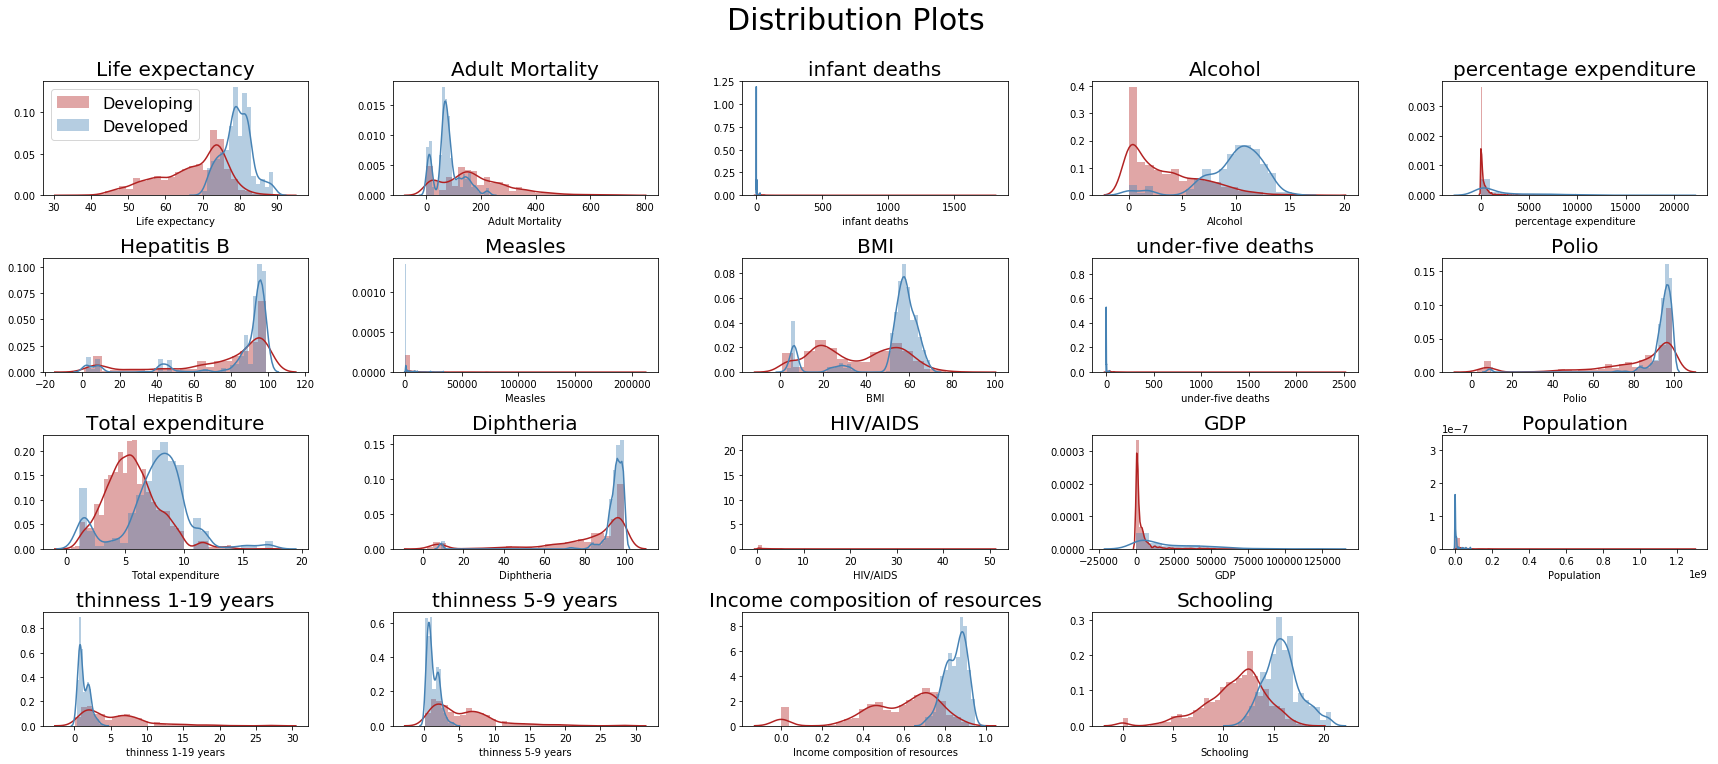

In [18]:
plot_cont_vars(df, plot_type='dist')

### Box plots for each continuous variable

No handles with labels found to put in legend.


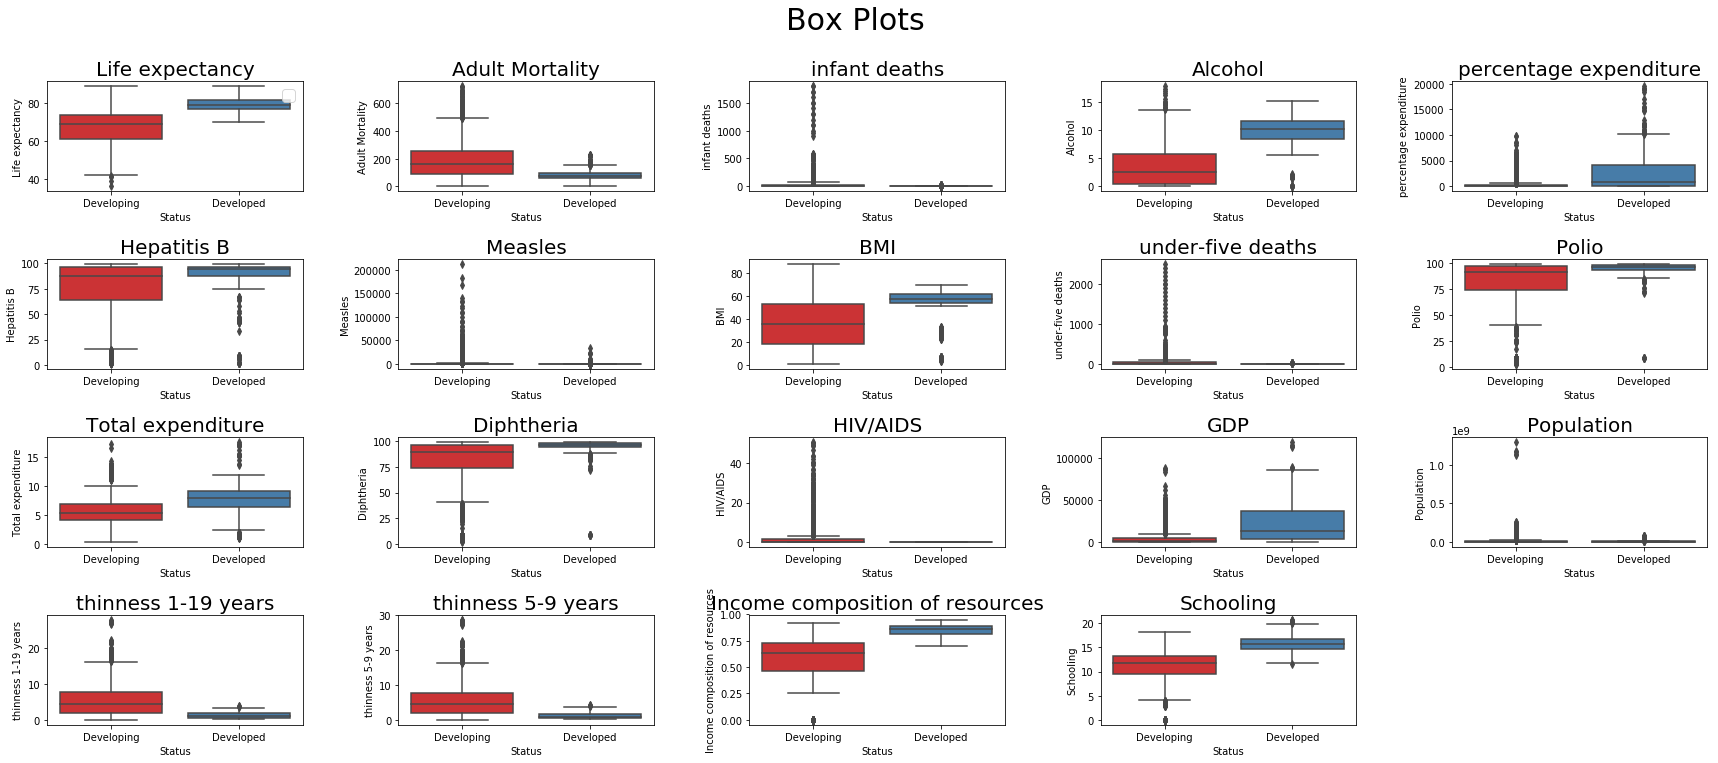

In [19]:
plot_cont_vars(df, plot_type='box')

#### Observations, dist and box plots
 - Each variable has many outliers that need to be dealt with

### Apply winsorization to each variable, but group the column data by Status (Developing | Developed)
 - The ranges and outliers for Developing and Developed countries differ vastly from one another and will be winsorized separately.

#### Define winsorization wrapper function

In [20]:
def winsorize_vars(df):

    # create a new data frame for winsorized data
    my_df = df.copy()

    # winsorize life expectancy
    my_df.loc[df['Status'] == 'Developing', 'Life expectancy'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Life expectancy'], (0.01, 0))

    # winsorize Adult Mortality
    my_df.loc[df['Status'] == 'Developing', 'Adult Mortality'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Adult Mortality'], (0.0, 0.03))
    my_df.loc[df['Status'] == 'Developed', 'Adult Mortality'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Adult Mortality'], (0.0, 0.1))

    # winsorize infant deaths
    my_df.loc[df['Status'] == 'Developing', 'infant deaths'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'infant deaths'], (0.0, 0.09))
    my_df.loc[df['Status'] == 'Developed', 'infant deaths'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'infant deaths'], (0.0, 0.13))

    # winsorize Alcohol
    my_df.loc[df['Status'] == 'Developing', 'Alcohol'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Alcohol'], (0.0, 0.02))
    my_df.loc[df['Status'] == 'Developed', 'Alcohol'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Alcohol'], (0.06, 0))

    # winsorize percentage expenditure
    my_df.loc[df['Status'] == 'Developing', 'percentage expenditure'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'percentage expenditure'], (0, 0.07))
    my_df.loc[df['Status'] == 'Developed', 'percentage expenditure'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'percentage expenditure'], (0, 0.06))

    # winsorize Hepatitis B
    my_df.loc[df['Status'] == 'Developing', 'Hepatitis B'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Hepatitis B'], (0.1, 0))
    my_df.loc[df['Status'] == 'Developed', 'Hepatitis B'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Hepatitis B'], (0.12, 0))

    # winsorize Measles
    my_df.loc[df['Status'] == 'Developing', 'Measles'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Measles'], (0, 0.19))
    my_df.loc[df['Status'] == 'Developed', 'Measles'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Measles'], (0, 0.16))

    # winsorize BMI
    my_df.loc[df['Status'] == 'Developed', 'BMI'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'BMI'], (0.16, 0))

    # winsorize under-five deaths
    my_df.loc[df['Status'] == 'Developing', 'under-five deaths'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'under-five deaths'], (0, 0.1))
    my_df.loc[df['Status'] == 'Developed', 'under-five deaths'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'under-five deaths'], (0, 0.04))

    # winsorize Polio
    my_df.loc[df['Status'] == 'Developing', 'Polio'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Polio'], (0.09, 0))
    my_df.loc[df['Status'] == 'Developed', 'Polio'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Polio'], (0.06, 0))

    # winsorize Total expenditure
    my_df.loc[df['Status'] == 'Developing', 'Total expenditure'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Total expenditure'], (0, 0.04))
    my_df.loc[df['Status'] == 'Developed', 'Total expenditure'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Total expenditure'], (0.11, 0.04))

    # winsorize Diphtheria
    my_df.loc[df['Status'] == 'Developing', 'Diphtheria'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Diphtheria'], (0.1, 0))
    my_df.loc[df['Status'] == 'Developed', 'Diphtheria'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Diphtheria'], (0.07, 0))

    # winsorize HIV/AIDS
    my_df.loc[df['Status'] == 'Developing', 'HIV/AIDS'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'HIV/AIDS'], (0, 0.16))
    my_df.loc[df['Status'] == 'Developed', 'HIV/AIDS'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'HIV/AIDS'], (0, 0))

    # winsorize GDP
    my_df.loc[df['Status'] == 'Developing', 'GDP'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'GDP'], (0, 0.19))
    my_df.loc[df['Status'] == 'Developed', 'GDP'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'GDP'], (0, 0.13))

    # winsorize Population
    my_df.loc[df['Status'] == 'Developing', 'Population'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Population'], (0, 0.24))
    my_df.loc[df['Status'] == 'Developed', 'Population'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Population'], (0, 0.22))

    # winsorize thinness 1-19 years
    my_df.loc[df['Status'] == 'Developing', 'thinness 1-19 years'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'thinness 1-19 years'], (0, 0.05))
    my_df.loc[df['Status'] == 'Developed', 'thinness 1-19 years'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'thinness 1-19 years'], (0, 0.01))

    # winsorize thinness 5-9 years
    my_df.loc[df['Status'] == 'Developing', 'thinness 5-9 years'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'thinness 5-9 years'], (0, 0.05))
    my_df.loc[df['Status'] == 'Developed', 'thinness 5-9 years'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'thinness 5-9 years'], (0, 0.01))

    # winsorize Income composition of resources
    my_df.loc[df['Status'] == 'Developing', 'Income composition of resources'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Income composition of resources'], (0.06, 0))

    # winsorize Schooling
    my_df.loc[df['Status'] == 'Developing', 'Schooling'] = winsorize(my_df.loc[df['Status'] == 'Developing', 'Schooling'], (0.05, 0))
    my_df.loc[df['Status'] == 'Developed', 'Schooling'] = winsorize(my_df.loc[df['Status'] == 'Developed', 'Schooling'], (0.01, 0.1))
    
    return my_df

### Distribution plots (winsorized)

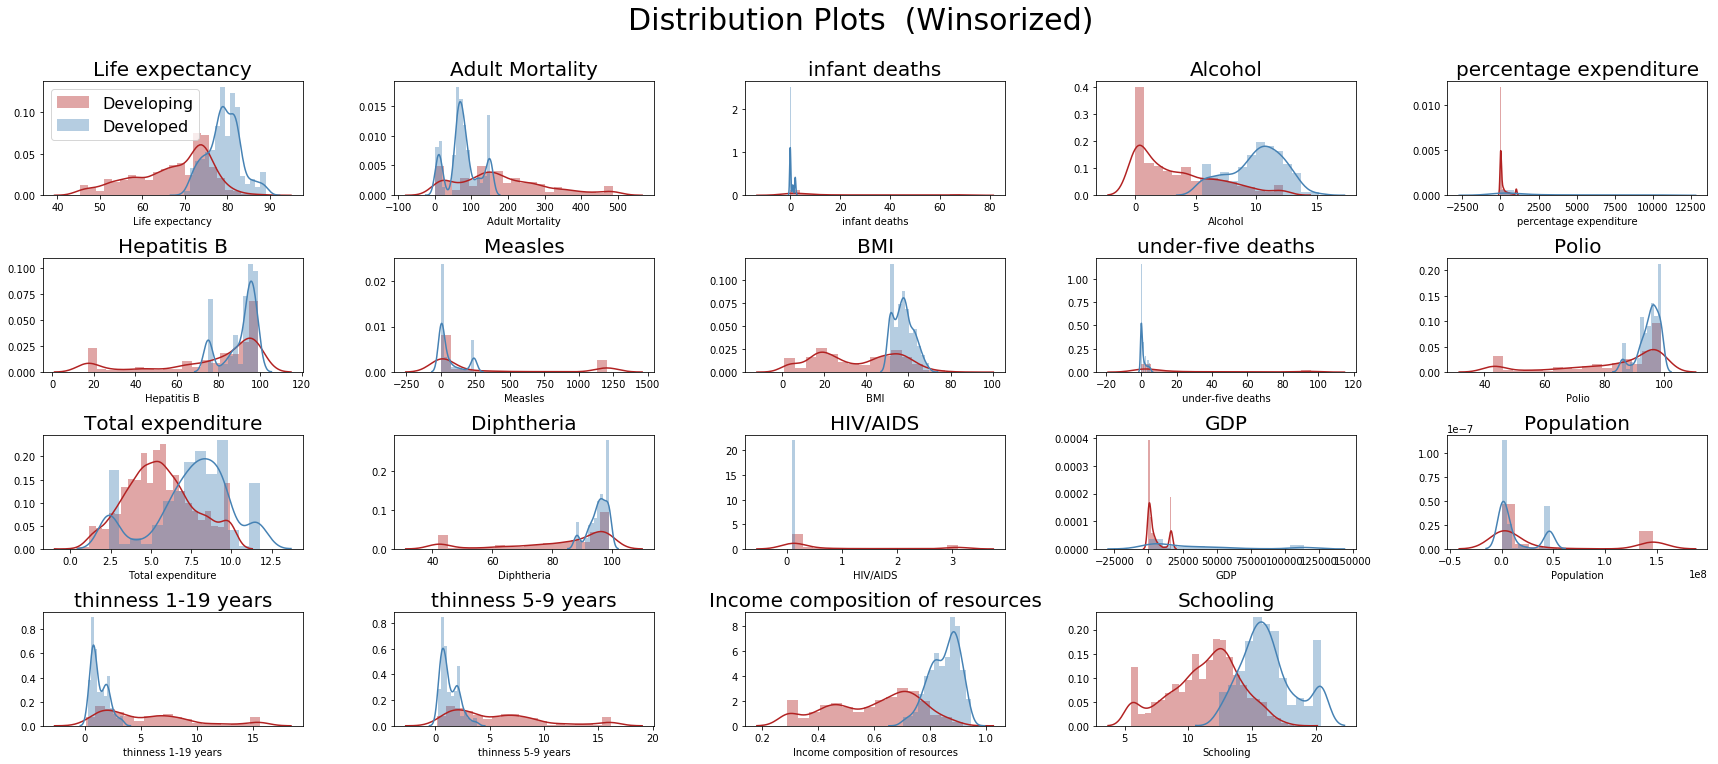

In [21]:
df_win = df.copy()
df_win = winsorize_vars(df_win)
plot_cont_vars(df_win, plot_type='dist', winsorized=True)

### Box plots (winsorized)

No handles with labels found to put in legend.


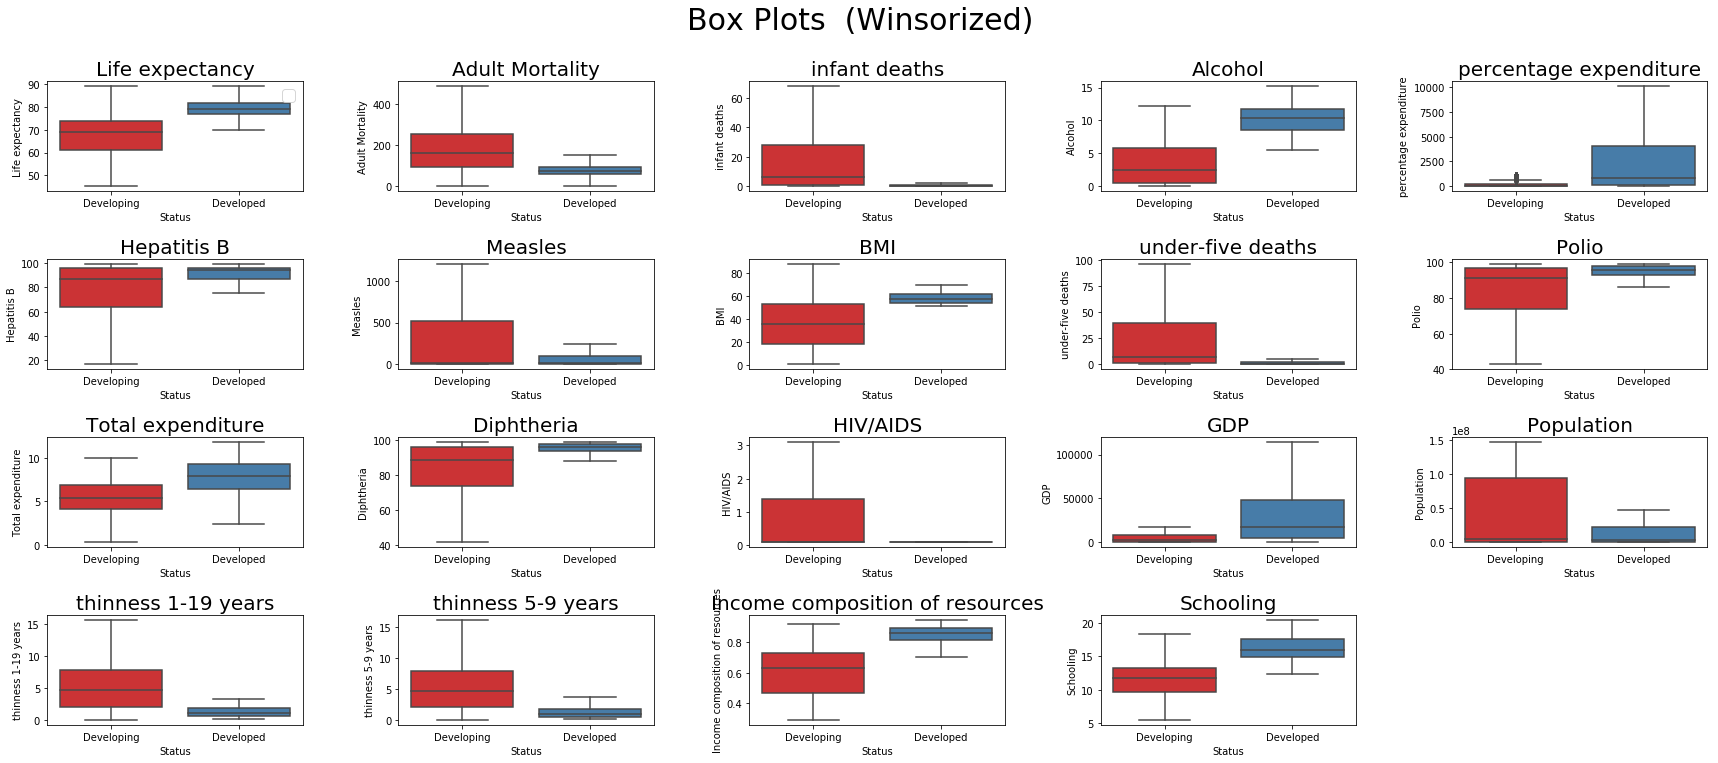

In [22]:
plot_cont_vars(df_win, plot_type='box', winsorized=True)

# DATA EXPLORATION

## Descriptive statistics of continuous variables

In [23]:
df_win.describe()

Life expectancy  Adult Mortality  infant deaths      Alcohol  \
count      2928.000000      2938.000000    2938.000000  2938.000000   
mean         69.239310       163.398911      14.653506     4.588392   
std           9.484343       118.891522      21.811987     4.036567   
min          45.300000         1.000000       0.000000     0.010000   
25%          63.100000        74.000000       0.000000     0.722500   
50%          72.100000       144.000000       3.000000     3.810000   
75%          75.700000       228.000000      21.000000     7.717500   
max          89.000000       486.000000      68.000000    15.190000   

       percentage expenditure  Hepatitis B      Measles          BMI  \
count             2938.000000  2794.000000  2938.000000  2904.000000   
mean               605.352531    77.625984   271.830837    39.342493   
std               1625.746274    25.593438   445.331080    19.646973   
min                  0.000000    17.000000     0.000000     1.000000   
25%                  4.685343    71.000000     0.000000    21.100000   
50%                 64.912906    89.000000    17.000000    45.400000   
75%                441.534144    96.000000   257.750000    56.200000   
max              10111.389280    99.000000  1205.000000    87.300000   

       under-five deaths        Polio  Total expenditure   Diphtheria  \
count        2938.000000  2938.000000        2938.000000  2938.000000   
mean           20.683118    84.707965           5.925948    84.554118   
std            31.506764    17.140067           2.322584    17.422467   
min             0.000000    43.000000           0.370000    42.000000   
25%             0.000000    78.000000           4.270000    78.000000   
50%             4.000000    93.000000           5.780000    93.000000   
75%            26.000000    97.000000           7.567500    97.000000   
max            96.000000    99.000000          11.800000    99.000000   

          HIV/AIDS            GDP    Population  thinness 1-19 years  \
count  2938.000000    2938.000000  2.938000e+03          2938.000000   
mean      0.728727   10072.602347  3.669758e+07             4.837100   
std       1.085092   19760.613877  5.724450e+07             4.119628   
min       0.100000       1.681350  3.400000e+01             0.100000   
25%       0.100000     555.356624  4.189172e+05             1.600000   
50%       0.100000    2791.697695  3.625718e+06             3.400000   
75%       0.800000   15706.454807  4.644770e+07             7.300000   
max       3.100000  114293.843300  1.465966e+08            15.600000   

       thinness 5-9 years  Income composition of resources    Schooling  
count         2938.000000                      2771.000000  2823.000000  
mean             4.873792                         0.641253    12.219412  
std              4.209072                         0.176322     3.288627  
min              0.100000                         0.290000     5.500000  
25%              1.600000                         0.493000    10.100000  
50%              3.400000                         0.677000    12.400000  
75%              7.300000                         0.779000    14.400000  
max             16.200000                         0.948000    20.400000

## Continuous variables over the years

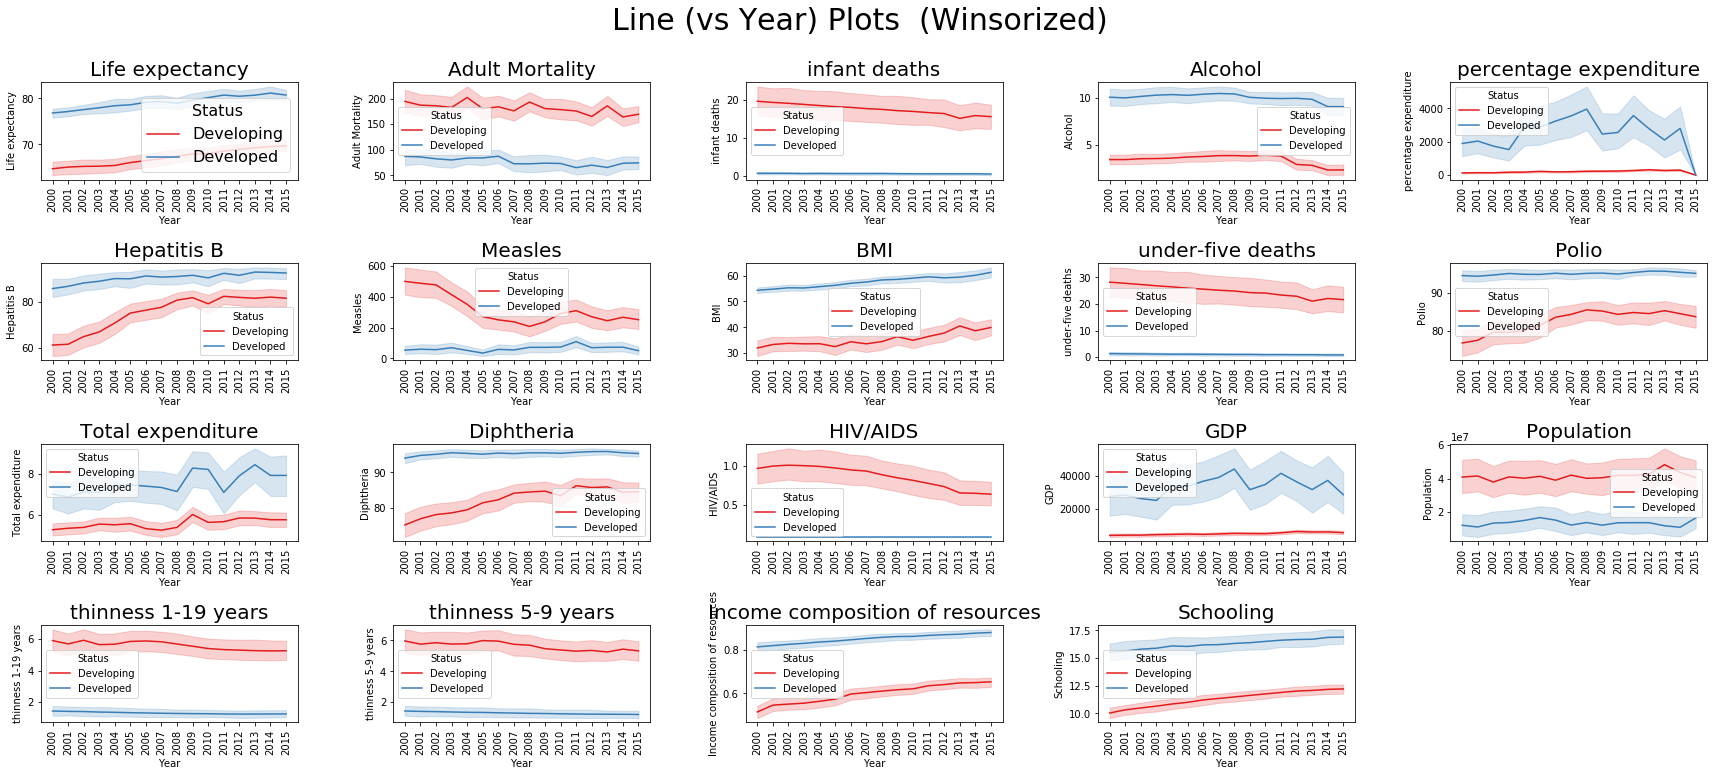

In [24]:
plot_cont_vars(df_win, plot_type='line', winsorized=True)

#### Observations, line plots:
 - There is a clear difference between the means of Life expectancy over the years for Developing and Developed countries
 - Visual inspection shows Life expectancy, income composition of resources, and Schooling to have the most similar trends over the years for both Developing and Developed countries

## Checking the difference in Life expectancy between Developing and Developed countries

In [25]:
for var in cont_vars:
    for year in sorted(df['Year'].unique()):
        #print(year, ttest_ind(df[(df['Status'] == 'Developing') & (df['Year'] == year)]['Life expectancy'].dropna(),df[(df['Status'] == 'Developed') & (df['Year'] == year)]['Life expectancy'].dropna()))
        print(var, year, ttest_ind(df[(df['Status'] == 'Developing') & (df['Year'] == year)][var].dropna(),df[(df['Status'] == 'Developed') & (df['Year'] == year)][var].dropna()))
    print('----------------------------------------------------------------------------------------------------')


Life expectancy 2000 Ttest_indResult(statistic=-6.793134465815448, pvalue=1.5272373868268973e-10)
Life expectancy 2001 Ttest_indResult(statistic=-6.835812844272693, pvalue=1.2059513768678602e-10)
Life expectancy 2002 Ttest_indResult(statistic=-7.119129064936526, pvalue=2.4636427434450723e-11)
Life expectancy 2003 Ttest_indResult(statistic=-7.339561887750881, pvalue=6.9945496786260336e-12)
Life expectancy 2004 Ttest_indResult(statistic=-7.55194740954528, pvalue=2.0415178987558702e-12)
Life expectancy 2005 Ttest_indResult(statistic=-7.542433674153067, pvalue=2.1580970792250966e-12)
Life expectancy 2006 Ttest_indResult(statistic=-7.605133509983277, pvalue=1.4957229693025398e-12)
Life expectancy 2007 Ttest_indResult(statistic=-7.6149409129792005, pvalue=1.4121747092171014e-12)
Life expectancy 2008 Ttest_indResult(statistic=-7.295594351989347, pvalue=9.00560650589805e-12)
Life expectancy 2009 Ttest_indResult(statistic=-7.671572917552774, pvalue=1.0126060966413822e-12)
Life expectancy 2010 T

BMI 2002 Ttest_indResult(statistic=-5.547057525708388, pvalue=1.0305408776349485e-07)
BMI 2003 Ttest_indResult(statistic=-4.618833317965784, pvalue=7.351975618682845e-06)
BMI 2004 Ttest_indResult(statistic=-4.64703264720356, pvalue=6.510008029044266e-06)
BMI 2005 Ttest_indResult(statistic=-4.605831721343653, pvalue=7.774661535006218e-06)
BMI 2006 Ttest_indResult(statistic=-4.927923501813618, pvalue=1.8842499577305826e-06)
BMI 2007 Ttest_indResult(statistic=-5.047086596396936, pvalue=1.096753344755068e-06)
BMI 2008 Ttest_indResult(statistic=-5.807208897978285, pvalue=2.8428495111562895e-08)
BMI 2009 Ttest_indResult(statistic=-4.917684424841462, pvalue=1.9731146546862083e-06)
BMI 2010 Ttest_indResult(statistic=-5.178655129571569, pvalue=5.972600048834876e-07)
BMI 2011 Ttest_indResult(statistic=-5.053514088528145, pvalue=1.0649328892420985e-06)
BMI 2012 Ttest_indResult(statistic=-3.313506792408208, pvalue=0.0011149675389562942)
BMI 2013 Ttest_indResult(statistic=-2.1982941203161017, pvalu

Population 2000 Ttest_indResult(statistic=1.091662526243836, pvalue=0.2768433126922975)
Population 2001 Ttest_indResult(statistic=1.3622716102124024, pvalue=0.1752843642466212)
Population 2002 Ttest_indResult(statistic=-0.25622818293179933, pvalue=0.7981481040457297)
Population 2003 Ttest_indResult(statistic=0.5282787616894657, pvalue=0.5981363480472889)
Population 2004 Ttest_indResult(statistic=0.4894791823875999, pvalue=0.6252631166005825)
Population 2005 Ttest_indResult(statistic=0.3710150267494156, pvalue=0.7111831889026907)
Population 2006 Ttest_indResult(statistic=0.31087013955834475, pvalue=0.7563584386830701)
Population 2007 Ttest_indResult(statistic=0.7009856315256344, pvalue=0.4844672155495119)
Population 2008 Ttest_indResult(statistic=0.6056244811989926, pvalue=0.5457377555744821)
Population 2009 Ttest_indResult(statistic=1.055683256844338, pvalue=0.29291843728883815)
Population 2010 Ttest_indResult(statistic=0.8423224731330775, pvalue=0.401033952931136)
Population 2011 Ttes

#### Life expectancy significance testing
 - From the Ttest results, the difference in life expectancy between Developing and Developed countries is significant.
 - We will continue to group our data by Status=Developing|Developed for analysis

## Correlation of continuous variables with Life expectancy

### Correlation plots, split by Status

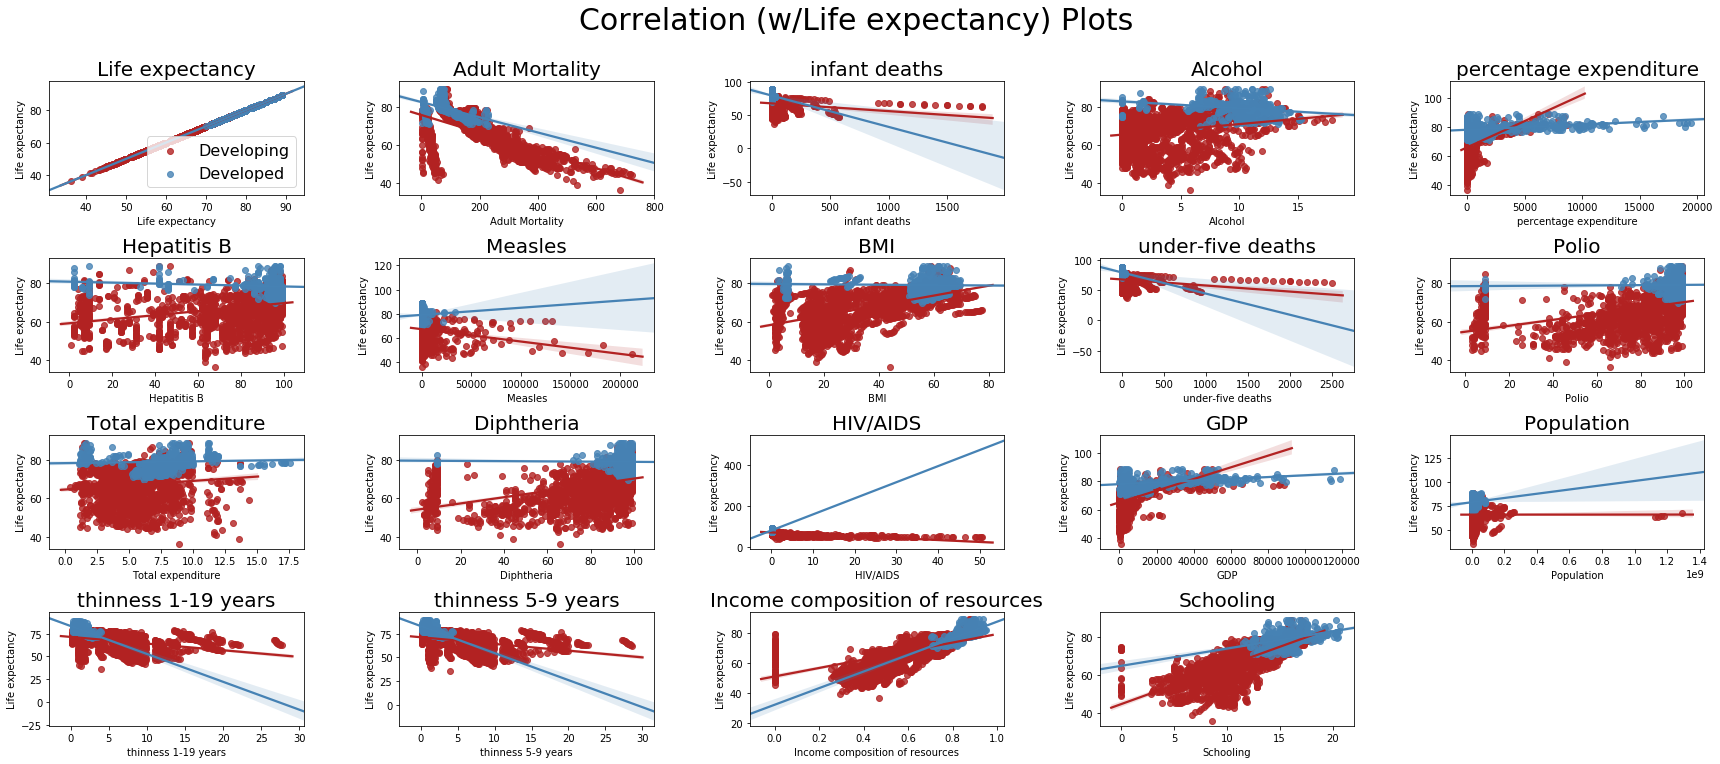

In [26]:
plot_cont_vars(df, plot_type='corr')

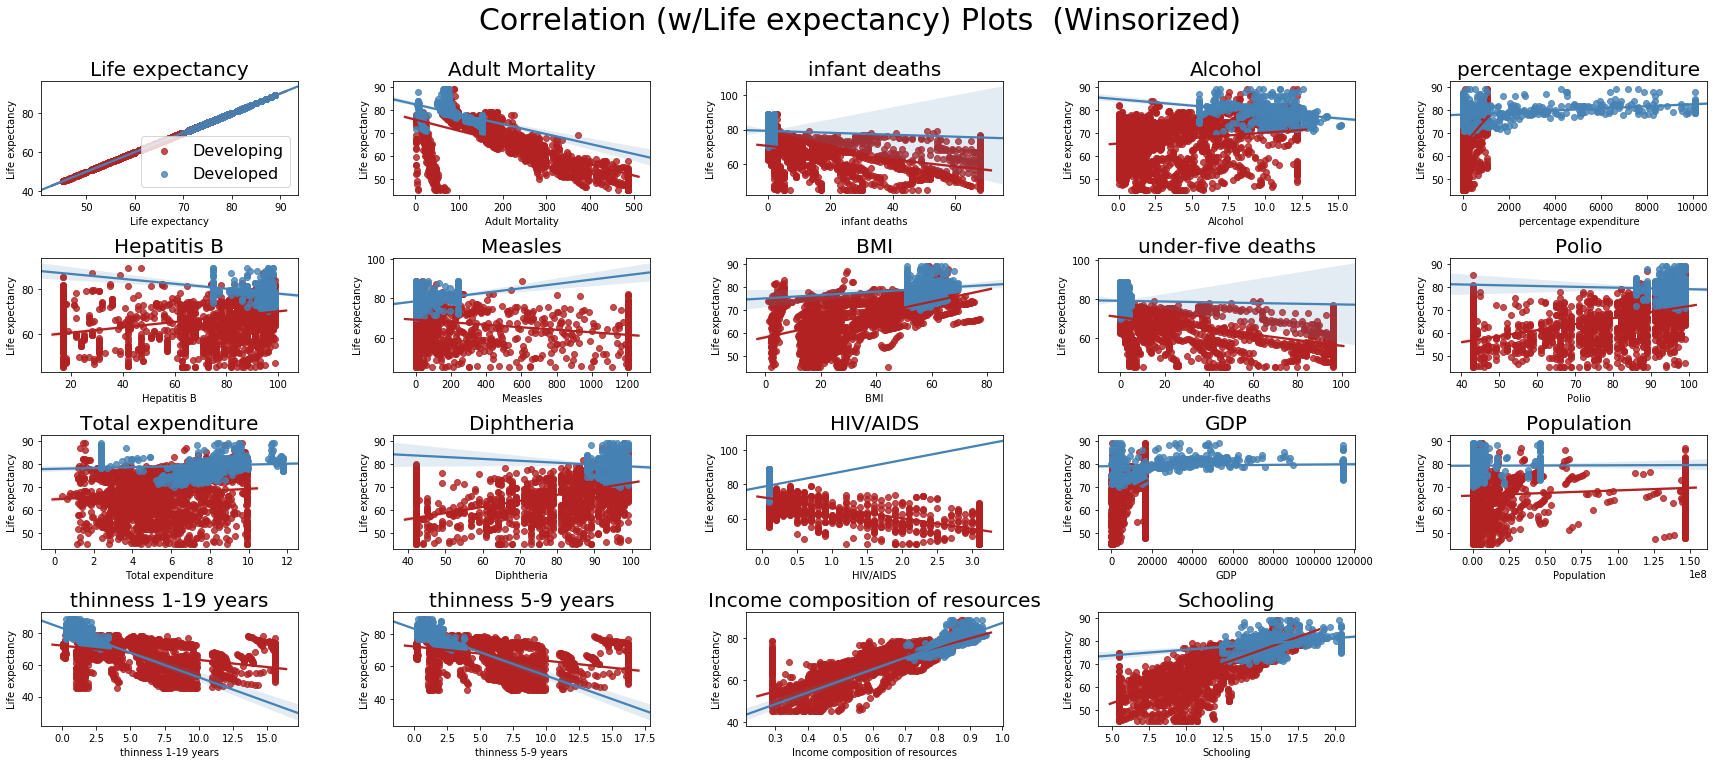

In [27]:
plot_cont_vars(df_win, plot_type='corr', winsorized=True)

### Inspection of Adult Mortality

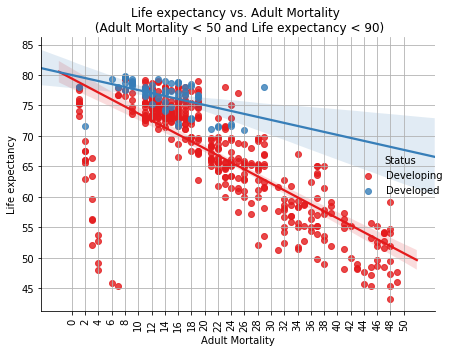

In [28]:
plt.rcParams["figure.figsize"] = (6,4)
sns.lmplot(data=df[(df['Adult Mortality']<50) & (df['Life expectancy'] < 80)], x='Adult Mortality', y='Life expectancy', hue='Status', palette='Set1')
plt.title('Life expectancy vs. Adult Mortality \n (Adult Mortality < 50 and Life expectancy < 90)')
plt.xticks(np.arange(0,52,2), rotation=90)
plt.grid()

plt.tight_layout()
plt.show()

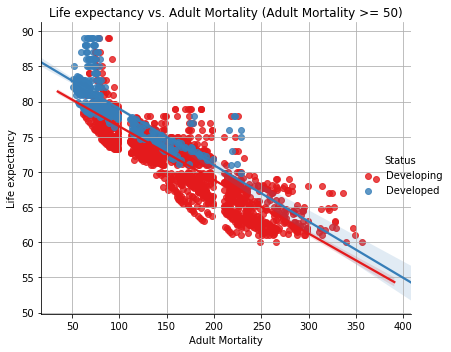

In [29]:
plt.rcParams["figure.figsize"] = (6,4)
sns.lmplot(data=df[(df['Adult Mortality']>=50) & (df['Life expectancy'] >= 60)], x='Adult Mortality', y='Life expectancy', hue='Status', palette='Set1')
plt.title('Life expectancy vs. Adult Mortality (Adult Mortality >= 50)')
plt.grid()

plt.tight_layout()
plt.show()

#### Observations, Adult Mortality groups
 - There appears to be 4 distinct groups of Adult Mortality rates, each correlating differently with Life expectancy
 - For correlation matrix, we will split into the two major groups above

### Inspection of Income composition of resources

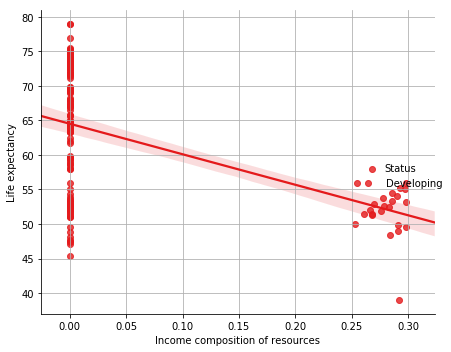

In [30]:
plt.rcParams["figure.figsize"] = (6,4)
sns.lmplot(data=df[df['Income composition of resources'] <0.3], x='Income composition of resources', y='Life expectancy', hue='Status', palette='Set1')
#plt.xticks(np.arange(0,50,2), rotation=90)
plt.grid()

plt.tight_layout()
plt.show()

#### Drop rows with values of 0 for Income composition of resources
 - these appear to be missing/incomplete data for multiple years for these countries
 - interpolation would not be sufficient in eliminating these as outliers

In [31]:
# get the indexes where the value is 0
indexes = df[df['Income composition of resources'] == 0].index

# drop the desired rows using the determined indexes
df.drop(indexes, inplace=True)

### re-plot Correlation with Life expectancy

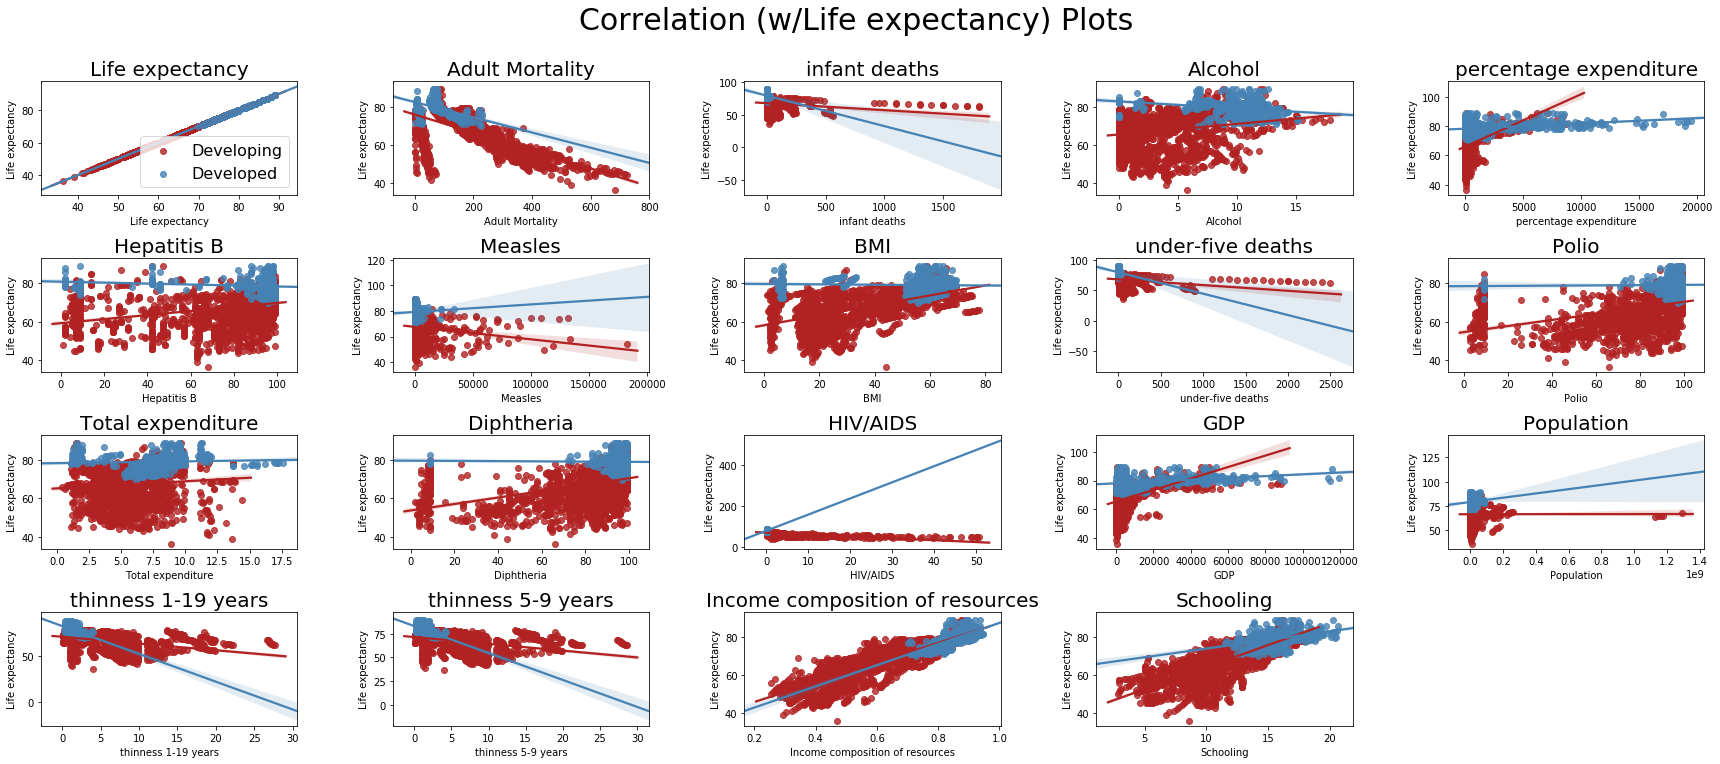

In [32]:
plot_cont_vars(df, plot_type='corr')

### re-plot Correlation with Life expectancy (winsorized)

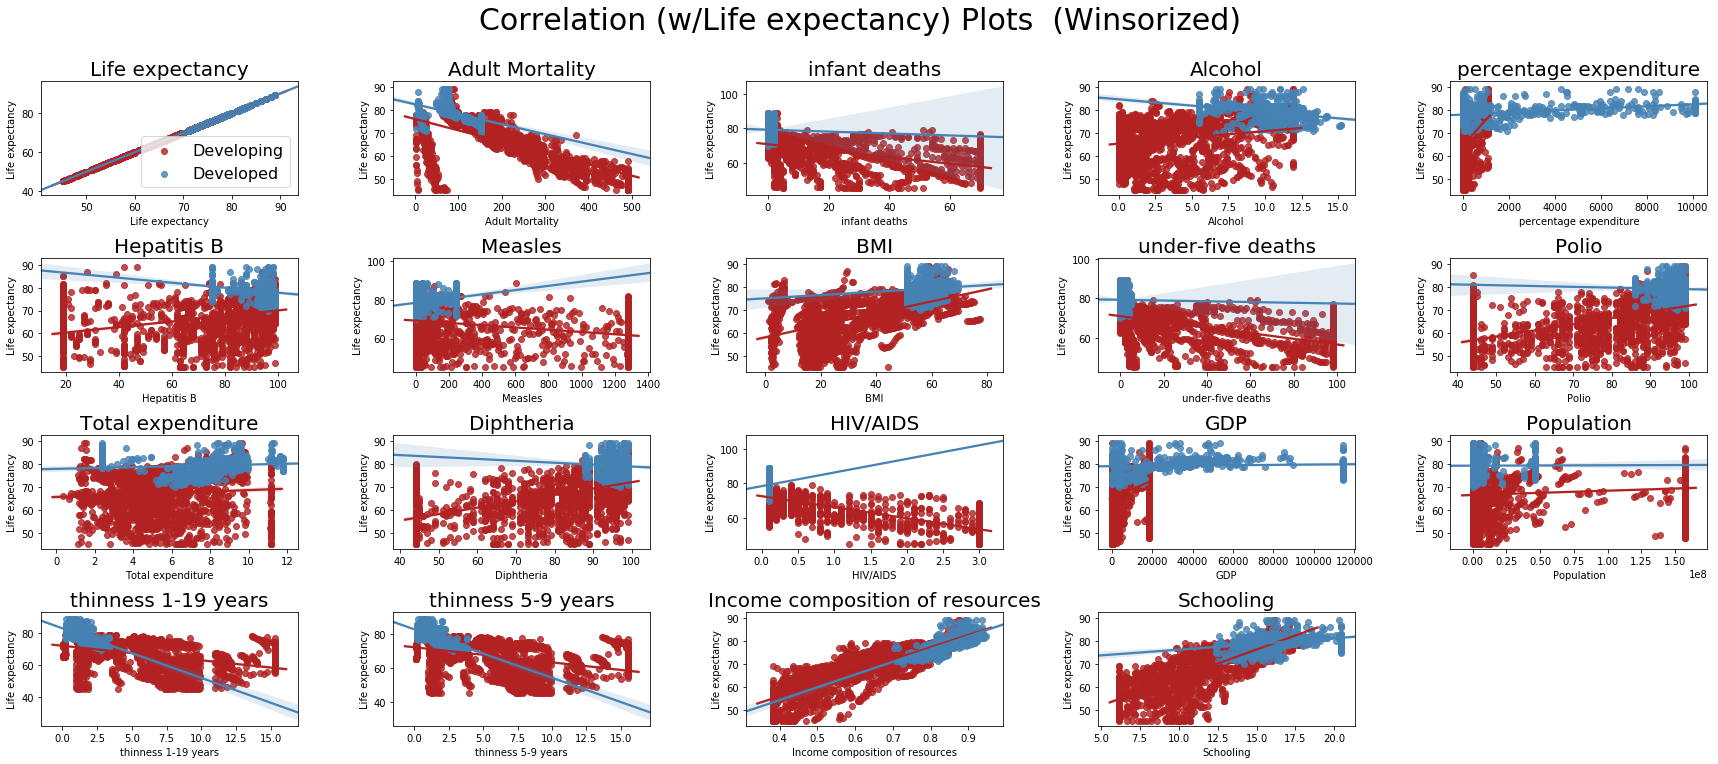

In [33]:
# start with copy of un-winsorized data set w/removed rows
df_win = df.copy()

# re-winsorize variables
df_win = winsorize_vars(df_win)

# plot correlation
plot_cont_vars(df_win, plot_type='corr', winsorized=True)

#### Observations, drop zeros for Income composition of resources
 - Correlation lines for Developing and Developed countries appear to lie on one another now after dropping 0 valued rows
 - Outliers for Schooling have also been removed as a result. This may indicate that whatever reason Income composition of resources was zero for these countries and years also affected Schooling (political upheaval? Missing records?)

### Inspection of Population

#### Transform Population with log

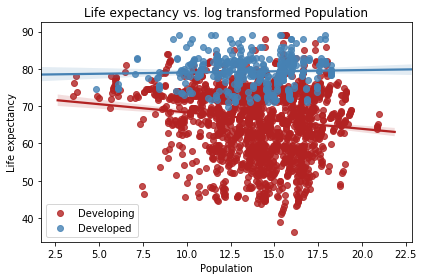

In [34]:
# set figure size
plt.rcParams["figure.figsize"] = (6,4)

# plot log transformed Population
sns.regplot(np.log(df[df['Status'] == 'Developing']['Population']),df[df['Status'] == 'Developing']['Life expectancy'], color='firebrick', label='Developing')
sns.regplot(np.log(df[df['Status'] == 'Developed']['Population']),df[df['Status'] == 'Developed']['Life expectancy'], color='steelblue', label='Developed')

# define plot title
plt.title('Life expectancy vs. log transformed Population')

# enable legend
plt.legend(loc=0)

plt.tight_layout()
plt.show()

#### winsorize log-transformed Population and plot

No handles with labels found to put in legend.


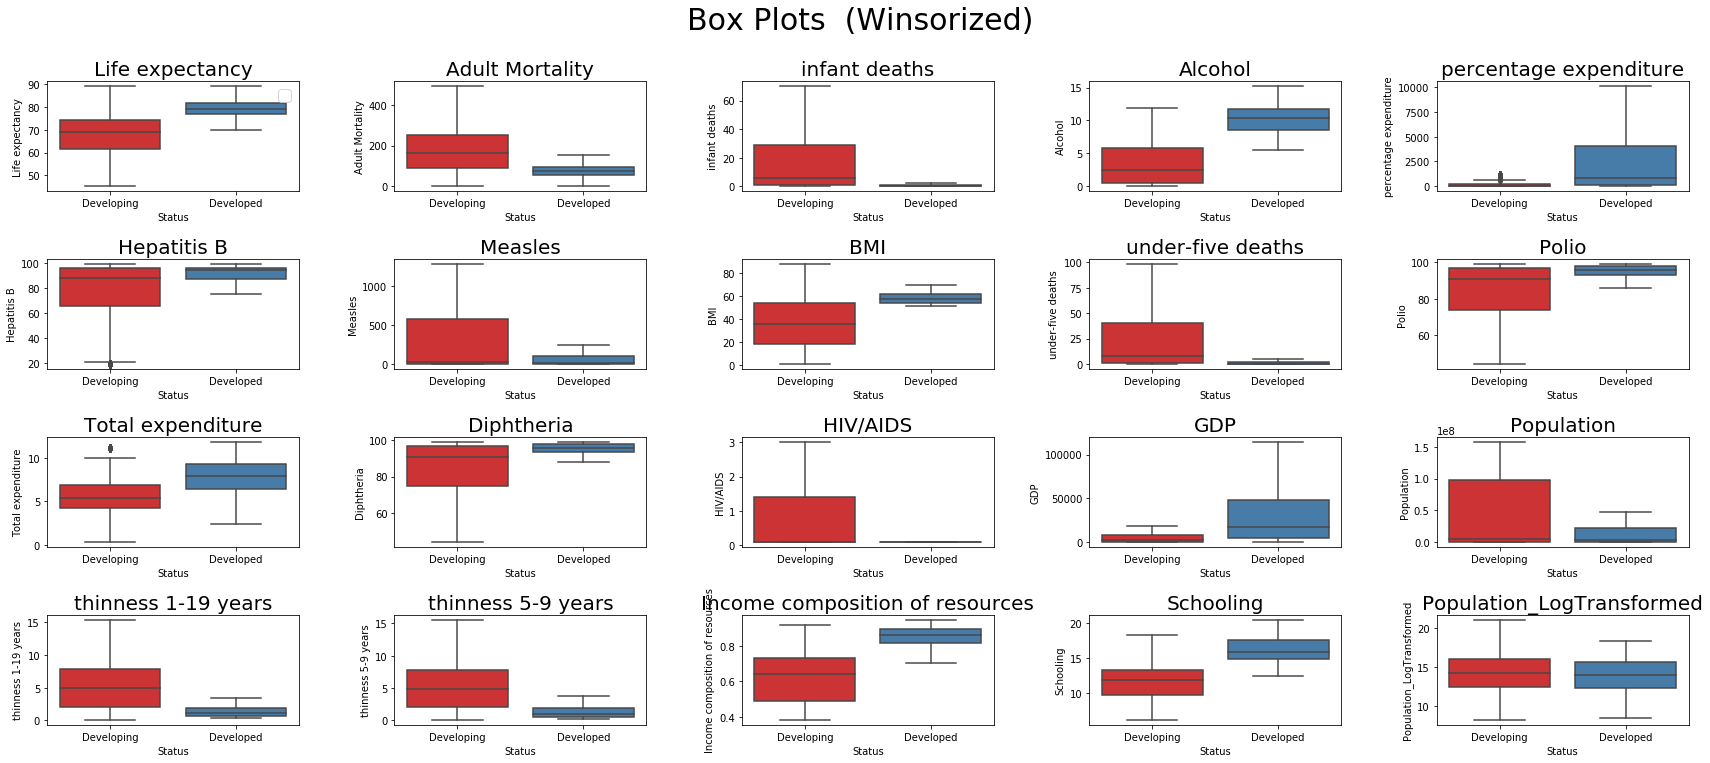

In [35]:
df['Population_LogTransformed'] = np.log(df['Population'])
cont_vars.append('Population_LogTransformed')

df_win = df.copy()
df_win = winsorize_vars(df_win)

# winsorize Population_LogTransformed
df_win.loc[df['Status'] == 'Developing', 'Population_LogTransformed'] = winsorize(df_win.loc[df['Status'] == 'Developing', 'Population_LogTransformed'], (0.02, 0))
df_win.loc[df['Status'] == 'Developed', 'Population_LogTransformed'] = winsorize(df_win.loc[df['Status'] == 'Developed', 'Population_LogTransformed'], (0.02, 0))
plot_cont_vars(df_win, plot_type='box', winsorized=True)


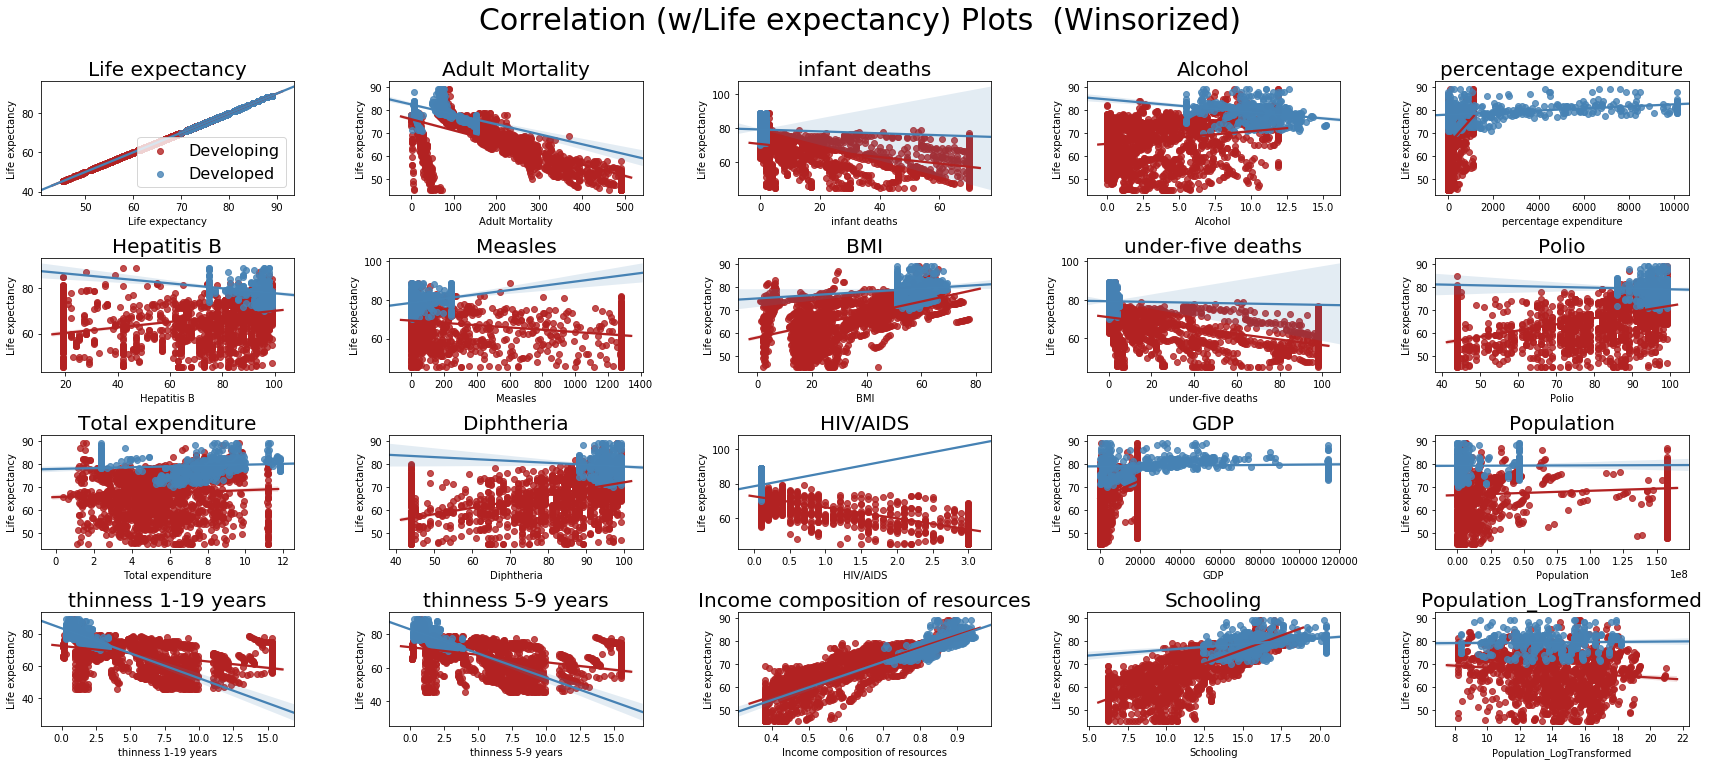

In [36]:
plot_cont_vars(df_win, plot_type='corr', winsorized=True)

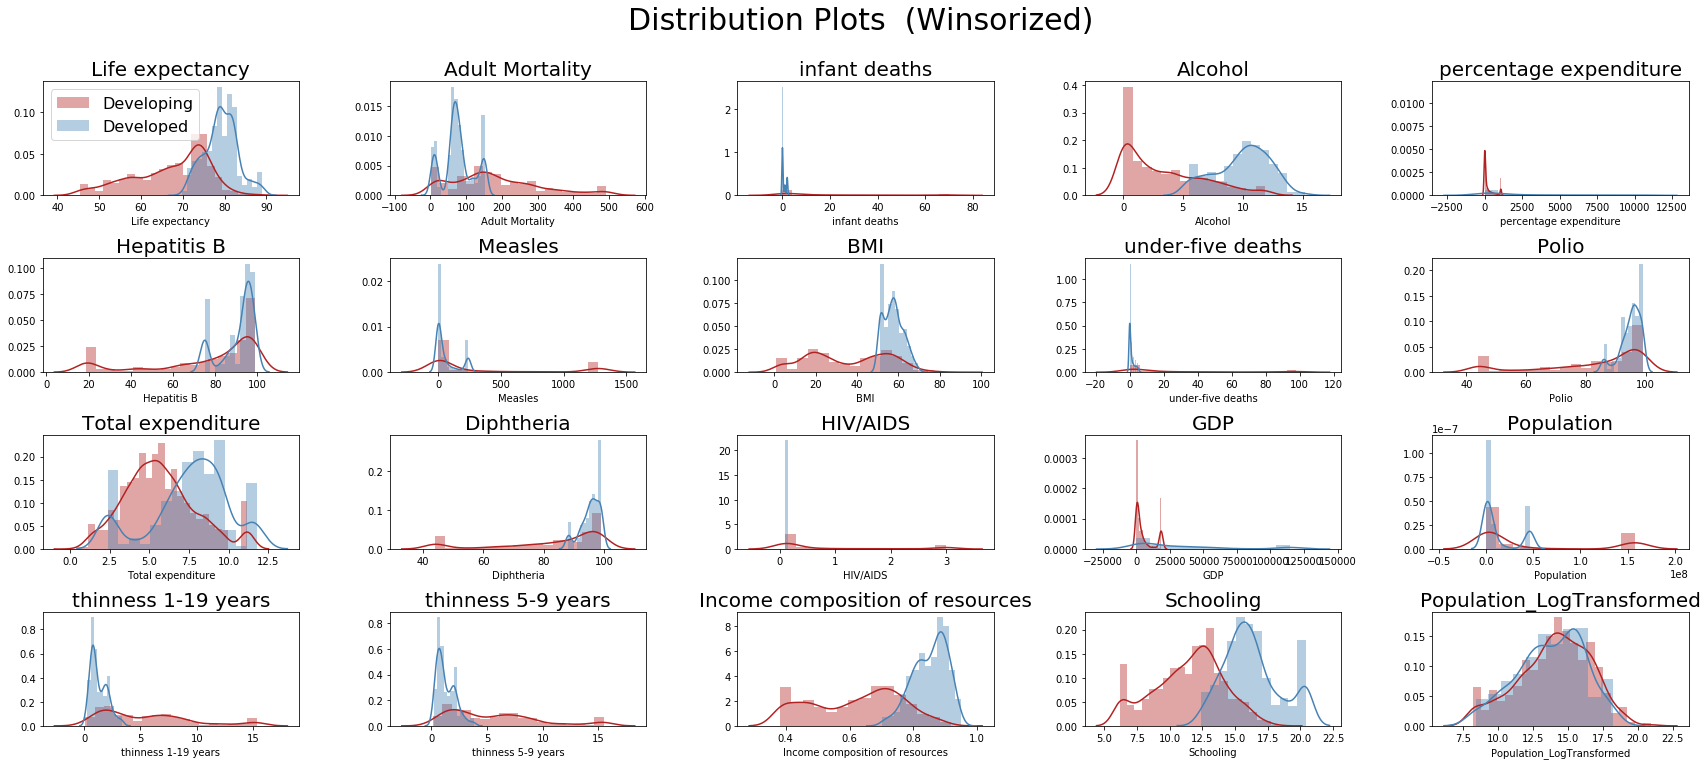

In [37]:
plot_cont_vars(df_win, plot_type='dist', winsorized=True)

#### Observations, Log transformed Population
 - Log-transformed Population is much closer to a normal distribution.
 - Correlation with Life expectancy appears to have improved and extreme outliers have been pulled in.

### Correlation heatmaps, split by Status

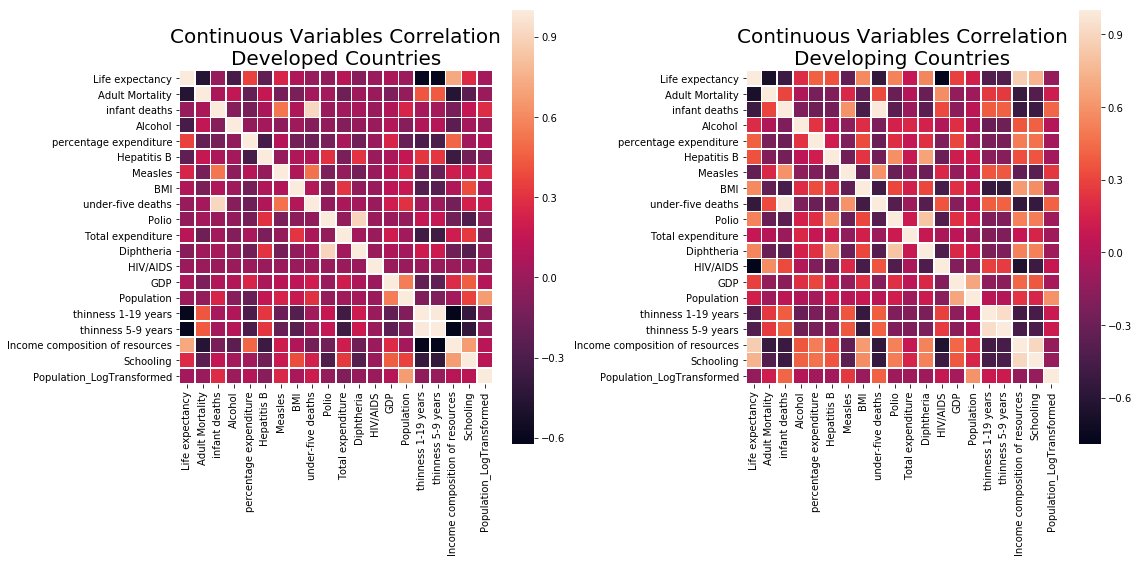

In [38]:
plt.rcParams["figure.figsize"] = (16,8)

plt.subplot(1,2,1)
sns.heatmap(df_win[df_win['Status'] == 'Developed'].corr(), square=True, annot=False, linewidths=0.5)
plt.title('Continuous Variables Correlation\nDeveloped Countries', fontsize=20)
plt.subplot(1,2,2)
sns.heatmap(df_win[df_win['Status'] == 'Developing'].corr(), square=True, annot=False, linewidths=0.5)
plt.title('Continuous Variables Correlation\nDeveloping Countries', fontsize=20)

plt.tight_layout()
plt.savefig('variables_win_correlation_heatmaps')
plt.savefig('continuous_variables_correlation_heatmaps_winsorized')
plt.show()

#### correlation heatmaps, observations:
---
##### Developed Countries
 - most **positively** correlating w/`Life expectancy`:
  - `Income composition of resources`
 - most **negatively** correlating w/`Life expectancy`:
  - `Adult Mortality (>=50)`
  - `thinness 5-9 years`
  - `thinness 1-19 years`
  - `Adult Mortality`

<br></br>
##### Developing Countries
 - most **positively** correlating w/`Life expectancy`:
  - `Income composition of resources`
  - `Schooling`
 - most **negatively** correlating w/`Life expectancy`:
  - `Adult Mortality (>=50)`
  - `HIV/AIDS`
  - `Adult Mortality (<50)`
  - `Adult Mortality`

#### Correlation with Life expectancy only, Developed countries only

In [39]:
df_win[df_win['Status'] == 'Developed'].corrwith(df_win[df_win['Status'] == 'Developed']['Life expectancy']).sort_values()

thinness 5-9 years                -6.006993e-01
thinness 1-19 years               -5.924926e-01
Adult Mortality                   -4.628905e-01
Alcohol                           -3.169665e-01
Hepatitis B                       -2.212905e-01
Diphtheria                        -6.620079e-02
Polio                             -3.022749e-02
infant deaths                     -1.199354e-02
under-five deaths                 -7.181541e-03
HIV/AIDS                           1.470082e-15
Population                         8.916989e-03
Population_LogTransformed          3.048889e-02
GDP                                6.702189e-02
BMI                                8.583781e-02
Total expenditure                  1.182093e-01
Measles                            2.507560e-01
Schooling                          2.697717e-01
percentage expenditure             3.655800e-01
Income composition of resources    7.240268e-01
Life expectancy                    1.000000e+00
dtype: float64

#### Correlation with Life expectancy only, Developing countries only

In [40]:
df_win[df_win['Status'] == 'Developing'].corrwith(df_win[df_win['Status'] == 'Developing']['Life expectancy']).sort_values()

HIV/AIDS                          -0.791924
Adult Mortality                   -0.666674
under-five deaths                 -0.542657
infant deaths                     -0.500347
thinness 1-19 years               -0.411550
thinness 5-9 years                -0.409195
Measles                           -0.333637
Population_LogTransformed         -0.121403
Total expenditure                  0.074929
Population                         0.137032
Alcohol                            0.200186
GDP                                0.292716
Hepatitis B                        0.354190
percentage expenditure             0.401284
Polio                              0.533193
Diphtheria                         0.546341
BMI                                0.559294
Schooling                          0.734028
Income composition of resources    0.856683
Life expectancy                    1.000000
dtype: float64

#### Correlation with Life expectancy only, Developed countries only, Adult Mortality >=50

In [41]:
df_win[(df_win['Status'] == 'Developed') & (df_win['Adult Mortality'] >= 50)].corrwith(df_win[(df_win['Status'] == 'Developed') & (df_win['Adult Mortality'] >= 50)]['Life expectancy']).sort_values()

Adult Mortality                   -8.362686e-01
thinness 5-9 years                -5.866097e-01
thinness 1-19 years               -5.723588e-01
Alcohol                           -2.872365e-01
Hepatitis B                       -2.216552e-01
Diphtheria                        -3.723618e-02
infant deaths                     -3.360136e-02
under-five deaths                 -3.287711e-02
Polio                             -1.159447e-02
HIV/AIDS                          -2.373092e-15
Population                         4.202122e-04
Population_LogTransformed          2.535842e-02
GDP                                4.691254e-02
BMI                                1.054179e-01
Total expenditure                  1.142605e-01
Measles                            2.152565e-01
Schooling                          2.931964e-01
percentage expenditure             3.309106e-01
Income composition of resources    7.070314e-01
Life expectancy                    1.000000e+00
dtype: float64

#### Correlation with Life expectancy only, Developed countries only, Adult Mortality < 50

In [42]:
df_win[(df_win['Status'] == 'Developed') & (df_win['Adult Mortality'] < 50)].corrwith(df_win[(df_win['Status'] == 'Developed') & (df_win['Adult Mortality'] < 50)]['Life expectancy']).sort_values()

thinness 1-19 years               -6.977735e-01
thinness 5-9 years                -6.807958e-01
Alcohol                           -4.437081e-01
Adult Mortality                   -2.489668e-01
Diphtheria                        -1.942134e-01
Hepatitis B                       -1.823138e-01
Polio                             -1.310400e-01
HIV/AIDS                          -1.485461e-15
BMI                                4.318118e-02
Population_LogTransformed          5.982442e-02
Population                         6.579322e-02
infant deaths                      1.063863e-01
under-five deaths                  1.272519e-01
GDP                                2.079945e-01
Total expenditure                  2.174707e-01
Schooling                          2.461594e-01
Measles                            4.388758e-01
percentage expenditure             5.428458e-01
Income composition of resources    8.103190e-01
Life expectancy                    1.000000e+00
dtype: float64

#### Correlation with Life expectancy only, Developing countries only, Adult Mortality >= 50

In [43]:
df_win[(df_win['Status'] == 'Developing') & (df_win['Adult Mortality'] >= 50)].corrwith(df_win[(df_win['Status'] == 'Developing') & (df_win['Adult Mortality'] >= 50)]['Life expectancy']).sort_values()

Adult Mortality                   -0.880296
HIV/AIDS                          -0.787539
under-five deaths                 -0.524910
infant deaths                     -0.481644
thinness 1-19 years               -0.417405
thinness 5-9 years                -0.416763
Measles                           -0.326233
Population_LogTransformed         -0.124221
Total expenditure                  0.066199
Population                         0.121398
Alcohol                            0.208567
GDP                                0.287002
Hepatitis B                        0.341480
percentage expenditure             0.382240
Polio                              0.516853
Diphtheria                         0.526217
BMI                                0.547366
Schooling                          0.723298
Income composition of resources    0.851625
Life expectancy                    1.000000
dtype: float64

#### Correlation with Life expectancy only, Developed countries only, Adult Mortality < 50

In [44]:
df_win[(df_win['Status'] == 'Developing') & (df_win['Adult Mortality'] < 50)].corrwith(df_win[(df_win['Status'] == 'Developing') & (df_win['Adult Mortality'] < 50)]['Life expectancy']).sort_values()

HIV/AIDS                          -0.814298
Adult Mortality                   -0.743576
under-five deaths                 -0.631930
infant deaths                     -0.595920
thinness 1-19 years               -0.379554
Measles                           -0.370566
thinness 5-9 years                -0.367662
Population_LogTransformed         -0.111305
Total expenditure                  0.126284
Alcohol                            0.159203
Population                         0.215211
GDP                                0.329845
Hepatitis B                        0.416629
percentage expenditure             0.498054
Polio                              0.614779
BMI                                0.618685
Diphtheria                         0.644969
Schooling                          0.786273
Income composition of resources    0.881934
Life expectancy                    1.000000
dtype: float64

# FEATURE ENGINEERING

## Feature Selection

<br></br>
### Status
 - We determined that for every year, `Life expectancy`, our target variable, is significantly different (w/p-values < 0.05) between Developed and Developing countries, the two values of the `Status` variable

<br></br>
### Correlating variables
 - Via correlation matrices and Seaborn regression plots, we determined the most positively and negatively correlating continuous variables for Developed and Developing countries. Each will be a feature in the model.
  - `Income composition of resources`
  - `Adult Mortality`
  - `thinness 5-9 years`
  - `thinness 1-19 years`
  - `Schooling`
  - `HIV/AIDS`
  

## Create new data frame for features and double check correlation

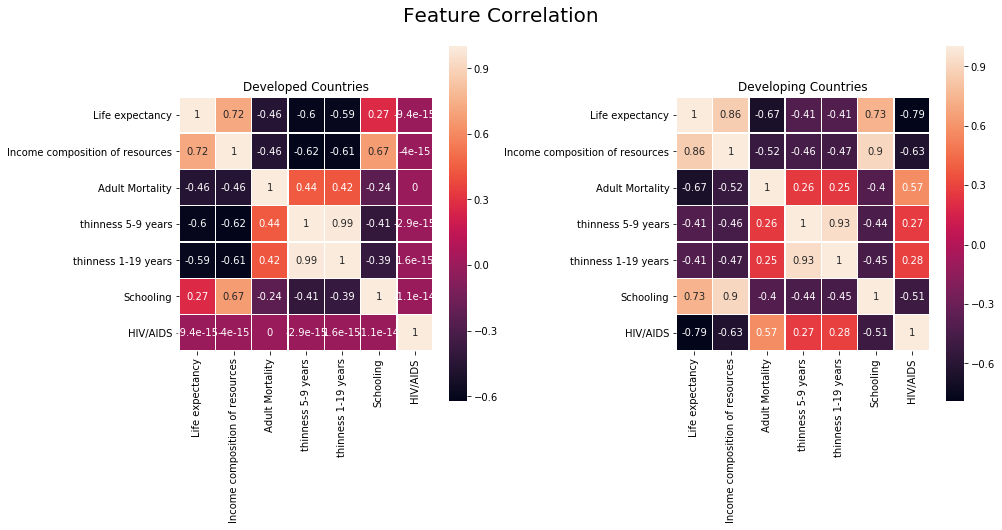

In [45]:
df_feat = df_win[['Life expectancy', 'Status', 'Income composition of resources', 'Adult Mortality', 'thinness 5-9 years', 'thinness 1-19 years', 'Schooling', 'HIV/AIDS']].copy()

plt.rcParams["figure.figsize"] = (14,7)

plt.subplot(1,2,1)
sns.heatmap(df_feat[df_feat['Status']=='Developed'].corr(), square=True, annot=True, linewidths=0.5)
plt.title('Developed Countries')

plt.subplot(1,2,2)
sns.heatmap(df_feat[df_feat['Status']=='Developing'].corr(), square=True, annot=True, linewidths=0.5)
plt.title('Developing Countries')

plt.suptitle('Feature Correlation', y=1.05, fontsize=20)

plt.tight_layout()
plt.show()

#### Observations, feature correlation
 - Income composition of resources is also correlated to Schooling, need to eliminate one
 - thinness 5-9 years is also correlated to thinness 1-19 years, need to eliminate one

## Eliminating inter-related features
> Some model types (such as regression) assume that features will be uncorrelated with each other, and high levels of interfeature correlation create unstable solutions.

In [46]:
df_feat[df_feat['Status'] == 'Developed'].corrwith(df_win[df_win['Status'] == 'Developed']['Life expectancy']).sort_values()

thinness 5-9 years                -6.006993e-01
thinness 1-19 years               -5.924926e-01
Adult Mortality                   -4.628905e-01
HIV/AIDS                           1.470082e-15
Schooling                          2.697717e-01
Income composition of resources    7.240268e-01
Life expectancy                    1.000000e+00
dtype: float64

In [47]:
df_feat[df_feat['Status'] == 'Developing'].corrwith(df_win[df_win['Status'] == 'Developing']['Life expectancy']).sort_values()

HIV/AIDS                          -0.791924
Adult Mortality                   -0.666674
thinness 1-19 years               -0.411550
thinness 5-9 years                -0.409195
Schooling                          0.734028
Income composition of resources    0.856683
Life expectancy                    1.000000
dtype: float64

#### Observation, feature elimination
 - Income composition of resources correlates more than Schooling with Life expectancy, keep it.
 - thinness 5-9 years correlates more than thinness 1-19 years with Life expectancy, keep it.

In [48]:
df_feat.drop(['Schooling','thinness 1-19 years'], axis=1, inplace=True)
df_feat.columns

Index(['Life expectancy', 'Status', 'Income composition of resources',
       'Adult Mortality', 'thinness 5-9 years', 'HIV/AIDS'],
      dtype='object')

## Convert categorical features to numeric values
> Machine learning models can only work with numeric variables. So, categorical variables that have text values need to be converted to numeric values.

In [49]:
# convert Status feature into an indicator feature using get_dummies
dummies = pd.get_dummies(df_feat['Status'], drop_first=True)

# concatenate converted Status feature into data frame
df_feat = pd.concat([df_feat, dummies], axis=1)

# drop original Status feature
df_feat = df_feat.drop(['Status'], axis=1)

df_feat.columns

Index(['Life expectancy', 'Income composition of resources', 'Adult Mortality',
       'thinness 5-9 years', 'HIV/AIDS', 'Developing'],
      dtype='object')

In [50]:
for col in df_feat.columns:
    #print(df_feat[col].isnull().sum())
    df_feat.dropna(inplace=True)

df_feat.head()

Life expectancy  Income composition of resources  Adult Mortality  \
0             65.0                            0.479            263.0   
1             59.9                            0.476            271.0   
2             59.9                            0.470            268.0   
3             59.5                            0.463            272.0   
4             59.2                            0.454            275.0   

   thinness 5-9 years  HIV/AIDS  Developing  
0                15.5       0.1           1  
1                15.5       0.1           1  
2                15.5       0.1           1  
3                15.5       0.1           1  
4                15.5       0.1           1

## Execute PCA

In [51]:
X = StandardScaler().fit_transform(df_feat[['Developing', 'Income composition of resources',
       'Adult Mortality', 'thinness 5-9 years', 'HIV/AIDS']])

sklearn_pca = PCA(n_components=5)
#df_feat['PCA_1'] = sklearn_pca.fit_transform(X)
pca_data = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.57925575 0.17249455 0.12013695 0.08063995 0.0474728 ]


In [52]:
pca_1 = []
pca_2 = []
pca_3 = []

for row in range(len(pca_data)):
    pca_1.append(pca_data[row][0])
    pca_2.append(pca_data[row][1])
    pca_3.append(pca_data[row][2])

df_feat['PCA_1'] = pca_1
df_feat['PCA_2'] = pca_2
df_feat['PCA_3'] = pca_3

In [53]:
df_feat.head()

Life expectancy  Income composition of resources  Adult Mortality  \
0             65.0                            0.479            263.0   
1             59.9                            0.476            271.0   
2             59.9                            0.470            268.0   
3             59.5                            0.463            272.0   
4             59.2                            0.454            275.0   

   thinness 5-9 years  HIV/AIDS  Developing     PCA_1     PCA_2     PCA_3  
0                15.5       0.1           1  1.996202 -1.328623  1.655304  
1                15.5       0.1           1  2.037575 -1.300274  1.648406  
2                15.5       0.1           1  2.046088 -1.313178  1.649525  
3                15.5       0.1           1  2.085323 -1.300757  1.644943  
4                15.5       0.1           1  2.127395 -1.292638  1.640733

In [54]:
df_feat[df_feat['Developing'] == 1].corrwith(df_feat[df_feat['Developing'] == 1]['Life expectancy']).sort_values()

PCA_1                             -0.886945
HIV/AIDS                          -0.792114
Adult Mortality                   -0.655304
PCA_2                             -0.621763
thinness 5-9 years                -0.400142
PCA_3                             -0.252191
Income composition of resources    0.856683
Life expectancy                    1.000000
Developing                              NaN
dtype: float64

In [55]:
df_feat[df_feat['Developing'] == 0].corrwith(df_feat[df_feat['Developing'] == 0]['Life expectancy']).sort_values()

PCA_1                             -0.741092
thinness 5-9 years                -0.614156
PCA_3                             -0.521020
Adult Mortality                   -0.492154
PCA_2                             -0.095447
Income composition of resources    0.724027
Life expectancy                    1.000000
HIV/AIDS                                NaN
Developing                              NaN
dtype: float64

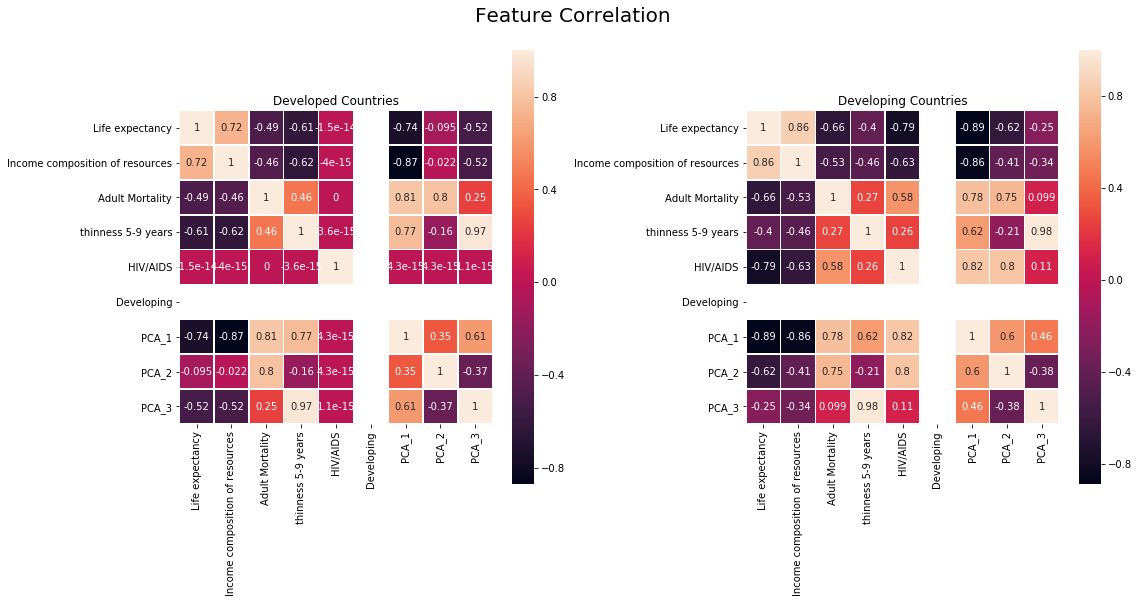

In [56]:
plt.rcParams["figure.figsize"] = (16,8)

plt.subplot(1,2,1)
sns.heatmap(df_feat[df_feat['Developing']==0].corr(), square=True, annot=True, linewidths=0.5)
plt.title('Developed Countries')

plt.subplot(1,2,2)
sns.heatmap(df_feat[df_feat['Developing']==1].corr(), square=True, annot=True, linewidths=0.5)
plt.title('Developing Countries')

plt.suptitle('Feature Correlation', y=1.05, fontsize=20)

plt.tight_layout()
plt.show()

#### Observations, PCA:
 - The first 3 components of PCA explain 87% of the total variance in the features.
 - PCA_1 correlates most negatively with Life expectancy.
 - PCA_1 correlates well with Adult Mortality, thinness 5-9 years, and HIV/AIDS so it can replace those as a final feature.
 - PCA_1 also correlates well with Income composition of resources, so it can replace that feature as well.
 - PCA_1 only covers 57% of the total variance, so we will include PCA_2 and PCA_3 as final features.

## Standardize/Normalize
> Some machine learning models assume that all features have values in the same range (e.g., a min of 0 and a max of 1) or they exhibit normal statistical properties. For some techniques, features that vary in range can result in incorrect estimates and results. To be able to apply these techniques and methods, we need to rescale our variables to fit a limited range, or standardize our variables to exhibit some regular statistical patterns. 

In [57]:
df_feat_normstd = df_feat[['Life expectancy', 'PCA_1', 'PCA_2', 'PCA_3']].copy()
df_feat_normstd.head()

Life expectancy     PCA_1     PCA_2     PCA_3
0             65.0  1.996202 -1.328623  1.655304
1             59.9  2.037575 -1.300274  1.648406
2             59.9  2.046088 -1.313178  1.649525
3             59.5  2.085323 -1.300757  1.644943
4             59.2  2.127395 -1.292638  1.640733

In [58]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

# normalize the winsorized variables
for col in df_feat_normstd.columns:
    df_feat_normstd[col] = normalize(np.array(df_feat_normstd[col].dropna()).reshape(1,-1)).reshape(-1,1)

# standardize the winsorized variables
for col in df_feat_normstd.columns:
    df_feat_normstd[col] = scale(df_feat[col])

df_feat_normstd.head()

Life expectancy     PCA_1     PCA_2     PCA_3
0        -0.496143  1.172963 -1.430636  2.135770
1        -1.045771  1.197273 -1.400110  2.126870
2        -1.045771  1.202276 -1.414005  2.128313
3        -1.088879  1.225330 -1.400630  2.122401
4        -1.121210  1.250052 -1.391888  2.116970

# Summary

<br></br>
## Data Cleaning
 - Columns were renamed to have consistent spacing by removing leading and trailing spaces and replacing double space with single space.
 - Missing or NULL values were dealt with by performing by-Country interpolation.
 - Rows that appeared to have incomplete data (Income composition, Schooling values were zero for multiple consecutive years) were dropped.
 - Winsorization was performed, split by Status value, to eliminate outliers.
---
<br></br>
## Data Exploration
 - Multiple continuous variables were found to correlate well negatively or positively with Life expectancy. Specifically, they were:
  1. `Income composition of resources`
  2. `Adult Mortality`
  3. `thinness 5-9 years`
  4. `thinness 1-19 years`
  5. `Schooling`
  6. `HIV/AIDS`
---
<br></br>
## Feature Engineering

<br></br>
 ### Feature selection
  - `Life expectancy` as the target variable was automatically selected.
  - In addition to the 6 correlating continuous variables, the `Status` variable was selected as a feature, for a total of 7 features.
  - Since Status was a categorical variable, with non-numeric text, Status was converted to a numeric column `Developing`. Status was henceforth dropped after conversion.

<br></br>
 ### Feature elimination
  - `Income composition of resources` correlated well with `Schooling`, so `Schooling` was dropped as a feature as it did not correlate with `Life expectancy` as well as the former.
  - `thinness 5-9 years` correlated well with `thinness 1-19 years` and better than the latter with `Life expectancy`, so the latter was dropped as feature.
  - This left the following features:
   1. `Life expectancy` - target variable
   2. `Developing` - indicator variable (0=Developed Country, 1=Developing Country)
   3. `Income composition of resources`
   4. `Adult Mortality`
   5. `thinness 5-9 years`
   6. `HIV/AIDS`

<br></br>
 ### PCA
  - PCA showed the first 3 components accounted for ~87% of the total variance.
  - Furthermore, PCA_1 correlated better with `Life expectancy` than all other continuous variables.
  - Since PCA_1 only accounts for 57% of the total variance, PCA_2 and PCA_3 should be included as features.
  
<br></br>
 ### Standardization / Normalization
  - Final features `Life expectancy`, `PCA_1`, `PCA_2`, `PCA_3` were then normalized (rescaling into the [0,1] range) and standardized (mean=0, stdev=1)
---  
<br></br>
## Final Model
##### As can be seen in the final correlation matrix below, PCA_1 correlates well with Life expectancy (-0.9).
 - `Life expectancy`
 - `PCA_1`
 - `PCA_2`
 - `PCA_3`

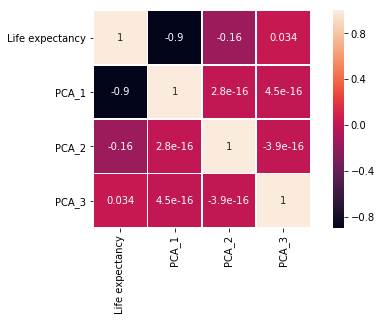

In [62]:
plt.rcParams["figure.figsize"] = (8,4)
sns.heatmap(df_feat_normstd.corr(), annot=True, square=True, linewidth=0.5)
plt.show()

df_feat_normstd.to_csv('Life_expectancy_model',index=False)